In [78]:
# Run some setup code for this notebook.
from __future__ import print_function

import random
import numpy as np
from utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading and Preprocessing

In [79]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_pub_test, y_pub_test
   del X_pri_test, y_pri_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_pub_test, y_pub_test, X_pri_test, y_pri_test = load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Public test labels shape: ', y_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('Private test labels shape: ', y_pri_test.shape)

Clear previously loaded data.
Training data shape:  (28709, 48, 48)
Training labels shape:  (28709,)
Public test data shape:  (3589, 48, 48)
Public test labels shape:  (3589,)
Private test data shape:  (3589, 48, 48)
Private test labels shape:  (3589,)


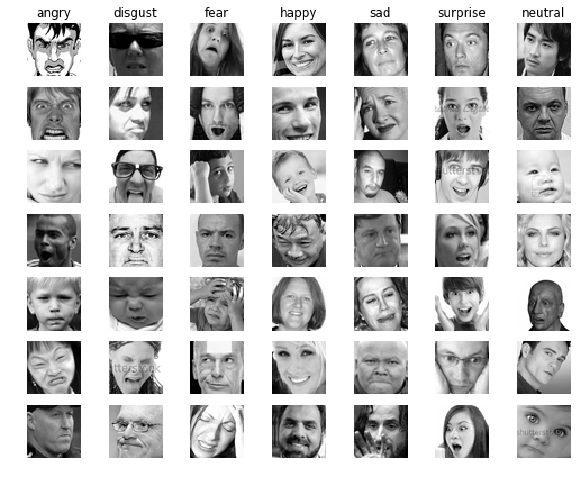

In [80]:
   classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
   num_classes = len(classes)
   samples_per_class = 7
   for y, cls in enumerate(classes):
       idxs = np.flatnonzero(y_train == y)
       idxs = np.random.choice(idxs, samples_per_class, replace=False)
       for i, idx in enumerate(idxs):
           plt_idx = i * num_classes + y + 1
           plt.subplot(samples_per_class, num_classes, plt_idx)
           plt.imshow(X_train[idx])
           plt.axis('off')
           if i == 0:
               plt.title(cls)
   plt.show()

In [81]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 27709
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_pub_test = X_pub_test[mask]
y_pub_test = y_pub_test[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_pri_test = X_pri_test[mask]
y_pri_test = y_pri_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Public test labels shape: ', y_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('Private test labels shape: ', y_pri_test.shape)

Train data shape:  (27709, 48, 48)
Train labels shape:  (27709,)
Validation data shape:  (1000, 48, 48)
Validation labels shape:  (1000,)
Public test data shape:  (1000, 48, 48)
Public test labels shape:  (1000,)
Private test data shape:  (1000, 48, 48)
Private test labels shape:  (1000,)


In [82]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_pub_test = np.reshape(X_pub_test, (X_pub_test.shape[0], -1))
X_pri_test = np.reshape(X_pri_test, (X_pri_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Public test data shape: ', X_pub_test.shape)
print('Private test data shape: ', X_pri_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (27709, 2304)
Validation data shape:  (1000, 2304)
Public test data shape:  (1000, 2304)
Private test data shape:  (1000, 2304)
dev data shape:  (500, 2304)


[120.2224548  117.12631275 114.12190985 111.6473348  109.41116605
 107.7168429  106.86585586 106.71673463 107.40315421 109.00750659]


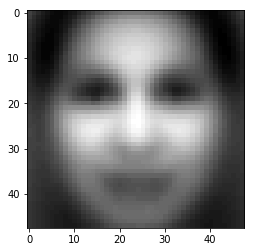

In [83]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((48, 48)).astype('uint8')) # visualize the mean image
plt.show()

In [84]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_pub_test -= mean_image
X_pri_test -= mean_image
X_dev -= mean_image

In [85]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_pub_test = np.hstack([X_pub_test, np.ones((X_pub_test.shape[0], 1))])
X_pri_test = np.hstack([X_pri_test, np.ones((X_pri_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])


print(X_train.shape, X_val.shape, X_pub_test.shape, X_pri_test.shape, X_dev.shape)

(27709, 2305) (1000, 2305) (1000, 2305) (1000, 2305) (500, 2305)


SVM Classifier

In [86]:
# Evaluate the naive implementation of the loss we provided for you:
from classifiers.linear_svm import *
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(2305, 7) * 0.0001 

loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 6.086236


In [87]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_vectorized(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 7.337699 analytic: 7.337699, relative error: 2.311077e-12
numerical: 0.448407 analytic: 0.448407, relative error: 7.144537e-11
numerical: -6.613487 analytic: -6.613487, relative error: 3.845826e-12
numerical: 14.500320 analytic: 14.500320, relative error: 5.243812e-13
numerical: -0.885807 analytic: -0.885807, relative error: 2.974129e-11
numerical: 15.804540 analytic: 15.804540, relative error: 1.239496e-12
numerical: -24.341301 analytic: -24.246075, relative error: 1.959891e-03
numerical: -10.683148 analytic: -10.788513, relative error: 4.907149e-03
numerical: 1.053218 analytic: 1.053218, relative error: 5.836374e-12
numerical: 13.854615 analytic: 13.854615, relative error: 1.437088e-12
numerical: 4.565077 analytic: 4.664176, relative error: 1.073749e-02
numerical: -20.059367 analytic: -20.059367, relative error: 2.039953e-12
numerical: 13.619802 analytic: 13.661605, relative error: 1.532271e-03
numerical: 0.787946 analytic: 0.787946, relative error: 3.702383e-12
numerical:

In [88]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))


# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 6.086236e+00 computed in 0.088762s
Vectorized loss: 6.086236e+00 computed in 0.004008s
difference: -0.000000


In [89]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.090316s
Vectorized loss and gradient: computed in 0.004002s
difference: 0.000000


# Stochastic Gradient Descent


In [90]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 412.203724
iteration 100 / 1500: loss 151.924466
iteration 200 / 1500: loss 58.415686
iteration 300 / 1500: loss 24.316213
iteration 400 / 1500: loss 12.031470
iteration 500 / 1500: loss 7.358088
iteration 600 / 1500: loss 5.660427
iteration 700 / 1500: loss 5.287997
iteration 800 / 1500: loss 5.107500
iteration 900 / 1500: loss 4.884060
iteration 1000 / 1500: loss 4.525775
iteration 1100 / 1500: loss 4.934283
iteration 1200 / 1500: loss 4.944968
iteration 1300 / 1500: loss 4.805232
iteration 1400 / 1500: loss 4.703060
That took 5.891923s


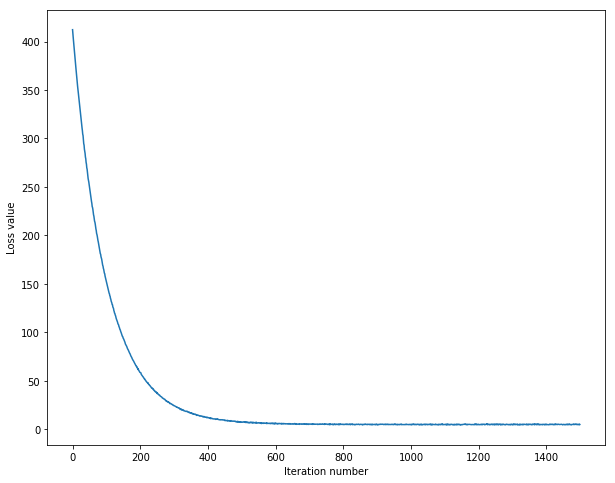

In [91]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [92]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.328161
validation accuracy: 0.288000


In [93]:
from random import uniform
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
# learning_rates = [1e-8, 1e-7, 2e-7, 5e-5]
# regularization_strengths = [1e4, 2e4, 2.5e4, 3e4, 4e4, 5e4]
# learning_rates = [1e-7]
# regularization_strengths = [2e4]
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Your code
#For each learning_rates and regularization_strengths
max_count = 100
for count in range(max_count):
        #print("(", count, "/", max_count, ")")
        reg = 10**uniform(-5, -1)
        lr = 10**uniform(-3, -6)
        #print("reg:", reg, "lr:", lr)
        #Create a LinearSVM object
        new_svm = LinearSVM()
        #Train the X-train, y_train
        new_loss_hist = new_svm.train(X_train, y_train, lr, reg, num_iters= 1500, verbose=False)
        #Calculate prediction on X_train
        new_y_train_pred = new_svm.predict(X_train)
        #Calculate accuracy on prediction on X_train
        train_acc = np.mean(y_train == new_y_train_pred)
        #Calculate prediction on X_val
        new_y_val_pred = new_svm.predict(X_val)
        #Calculate accuracy on prediction on X_val
        val_acc = np.mean(y_val == new_y_val_pred)
        #Store in results
        results[(lr, reg)] = (train_acc, val_acc)
        #Display the best accuracy
        if(val_acc > best_val):
            best_val = val_acc
            best_svm = new_svm
        #print("acc:", val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.005097e-06 reg 3.551457e-02 train accuracy: 0.347685 val accuracy: 0.309000
lr 1.025461e-06 reg 7.680162e-05 train accuracy: 0.336786 val accuracy: 0.298000
lr 1.037345e-06 reg 5.055047e-05 train accuracy: 0.355985 val accuracy: 0.315000
lr 1.195547e-06 reg 9.698344e-03 train accuracy: 0.311343 val accuracy: 0.256000
lr 1.227905e-06 reg 2.247233e-04 train accuracy: 0.343571 val accuracy: 0.285000
lr 1.333626e-06 reg 4.885000e-04 train accuracy: 0.339998 val accuracy: 0.321000
lr 1.339772e-06 reg 4.473964e-02 train accuracy: 0.347937 val accuracy: 0.311000
lr 1.349514e-06 reg 1.355557e-02 train accuracy: 0.337941 val accuracy: 0.285000
lr 1.436549e-06 reg 1.013238e-04 train accuracy: 0.341838 val accuracy: 0.294000
lr 1.441502e-06 reg 8.620969e-03 train accuracy: 0.355552 val accuracy: 0.301000
lr 1.446867e-06 reg 5.189884e-03 train accuracy: 0.328161 val accuracy: 0.275000
lr 1.698980e-06 reg 1.717167e-02 train accuracy: 0.355408 val accuracy: 0.297000
lr 1.805229e-06 reg 1.530456

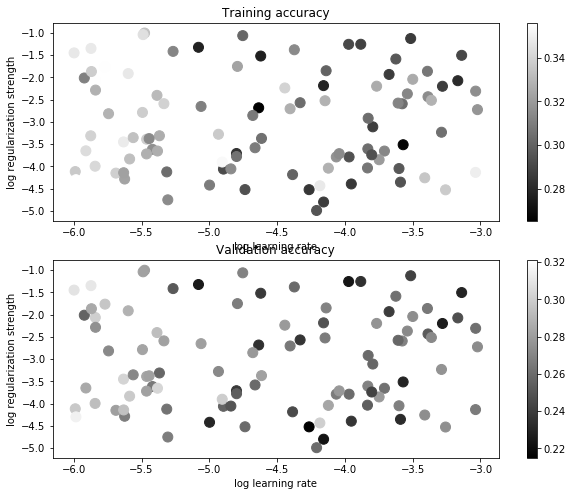

In [94]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Validation accuracy')
plt.show()

In [95]:
# Evaluate the best svm on public test set
y_pub_test_pred = best_svm.predict(X_pub_test)
test_pub_accuracy = np.mean(y_pub_test == y_pub_test_pred)
print('linear SVM on raw pixels public test set accuracy: %f' % test_pub_accuracy)

# Evaluate the best svm on private test set
y_pri_test_pred = best_svm.predict(X_pri_test)
test_pri_accuracy = np.mean(y_pri_test == y_pri_test_pred)
print('linear SVM on raw pixels private test set accuracy: %f' % test_pri_accuracy)

linear SVM on raw pixels public test set accuracy: 0.324000
linear SVM on raw pixels private test set accuracy: 0.337000


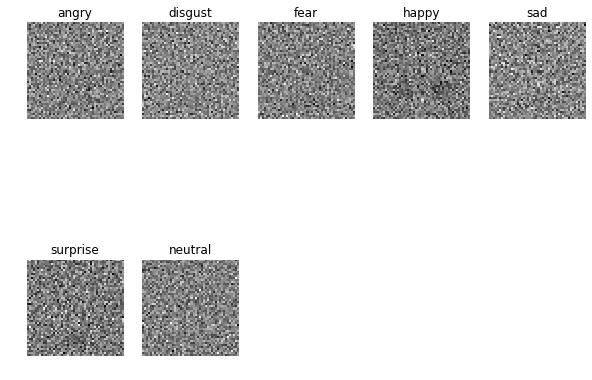

In [96]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(48, 48, 7)
w_min, w_max = np.min(w), np.max(w)
classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
for i in range(7):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])